In [4]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import openslide
from openslide.deepzoom import DeepZoomGenerator
from openslide import open_slide
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
import pickle
import numpy as np
import h5py
%matplotlib inline

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

# Load data

In [5]:
data_tile_number = 10
data_tile_level_index = -1
model_tile_number = 50
model_tile_level_index = -1
t = "Lung"
lung_full_representations = pickle.load(open('../data/processed/representations/all_lung_representations_model_{}_{}_gs{}_data_{}_{}'.format(model_tile_number,model_tile_level_index,1,data_tile_number,data_tile_level_index), 'rb'))
[lung_X, tl, lung_ID] = pickle.load(open('../data/processed/patches/lung_data_{}_{}_{}.py'.format(t,data_tile_number,data_tile_level_index), 'rb'))

In [20]:
lung_X[0].astype(np.float32)[:,:,2]

array([[ 0.2980957 ,  0.3137207 ,  0.36865234, ...,  0.05490112,
         0.05490112,  0.05490112],
       [ 0.27441406,  0.28637695,  0.3371582 , ...,  0.05490112,
         0.05490112,  0.05490112],
       [ 0.19604492,  0.20788574,  0.24707031, ...,  0.05099487,
         0.05099487,  0.05099487],
       ..., 
       [ 0.43530273,  0.41577148,  0.36474609, ...,  0.09411621,
         0.07452393,  0.07061768],
       [ 0.40380859,  0.38427734,  0.3215332 , ...,  0.09020996,
         0.07061768,  0.06665039],
       [ 0.39208984,  0.37255859,  0.30981445, ...,  0.09020996,
         0.07061768,  0.06665039]], dtype=float32)

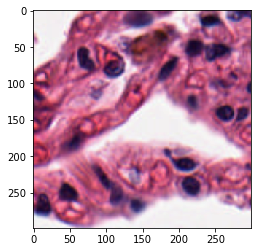

In [43]:
plt.imshow(1- lung_X[600].astype(np.float32))

# Aggregation

In [5]:
len(lung_full_representations)

3370

In [6]:
agg_lung_full_representations = []
for i in range(int(len(lung_full_representations) / 10)):
    reps_from_person = lung_full_representations[10*i:10*(i+1),:]
    agg_reps = np.mean(reps_from_person,axis=0)
    agg_lung_full_representations.append(agg_reps)
agg_lung_full_representations = np.array(agg_lung_full_representations)

print (agg_lung_full_representations.shape) #337

# Load and filter expression data for Lung

In [11]:
with open(lung_expression_filepath, 'r') as f:
    expression_table = np.array([x.split('\t') for x in f.read().splitlines()])

individual_lung_expression_donor_IDs = [x.split('-')[1] for x in expression_table[0,:][1:]]
print (len(individual_lung_expression_donor_IDs)) #278

individual_lung_image_donor_IDs = np.array(get_donor_IDs([lung_ID[data_tile_number*i] for i in range(int(len(lung_ID) / 10))]))
print (len(individual_lung_image_donor_IDs)) #337

# Filter image IDs to ones where RNA expression exists
rna_exists = np.array([x in individual_lung_expression_donor_IDs for x in individual_lung_image_donor_IDs])
print (sum(rna_exists)) #273
f_individual_lung_image_donor_IDs = individual_lung_image_donor_IDs[rna_exists]

#Find the unique indexes of these IDs in the individual donor IDs which correspond to a single aggregated representation.
f_individual_lung_IDs_reps_idx = np.unique([list(individual_lung_image_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_reps_idx)) #273

#Find the indexes of these IDs in the RNA expression
f_individual_lung_IDs_exp_idx = np.unique([list(individual_lung_expression_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_exp_idx)) #273

#Extract the correct data from the expression matrix and the aggregate representations.
expression_matrix = expression_table[1:,1:].astype(np.float32)

f_agg_lung_full_representations = agg_lung_full_representations[f_individual_lung_IDs_reps_idx,:]
f_expression_matrix = expression_matrix[:,f_individual_lung_IDs_exp_idx].T
print (f_agg_lung_full_representations.shape, f_expression_matrix.shape) # (273, 1024) (273, 28683)

278
337
273
273
273
(273, 1024) (273, 28683)


# Save processed data

In [12]:
pickle.dump([f_expression_matrix, f_agg_lung_full_representations], open('../data/processed/associations/all_lung_associations.py','wb'))